In [12]:
from pylab import rcParams
from osgeo import gdal
import mpl_toolkits.basemap
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# import numpy as np
import random as random
# import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from scipy.spatial import distance#
from pyproj import Proj,transform
import seaborn as sns
import copy
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import multiprocessing
from datetime import datetime

## Previous Cases

In [4]:
Data=pd.read_csv("cases.csv",sep = ',', header = 0)

#### read date

In [5]:
months = []
years = []
monthe = []
yeare = []
for i in range(len(Data)):
    months.append(int(float(Data['Start'].values[i].split('/')[0])))
    years.append(int(float(Data['Start'].values[i].split('/')[1])))
    monthe.append(int(float(Data['End'].values[i].split('/')[0])))
    yeare.append(int(float(Data['End'].values[i].split('/')[1])))

In [6]:
Data['Sm'] = months
Data['Sy'] = years
Data['Em'] = monthe
Data['Ey'] = yeare

In [14]:
date_format = "%m/%Y"
duration = []
for i in range(len(Data)):
    a = datetime.strptime(Data['Start'][i], date_format)
    b = datetime.strptime(Data['End'][i], date_format)
    delta = b - a
    duration.append(delta.days)

In [15]:
Data['Duration'] = duration

In [9]:
lons_india = Data['Long'][Data['country'] == 'I'].values
lats_india =Data['Lat'][Data['country'] == 'I'].values
lons_ban = Data['Long'][Data['country'] == 'B'].values
lats_ban =Data['Lat'][Data['country'] == 'B'].values

In [11]:
Case = [] #appends each day (so that the classes can be colour coordinated)
for year in range(1999, max(Data['Ey'])+1):
    for month in range(1,13):
        c = []
        for k in Data[Data['Sy'] == year].index.values:
            if Data.loc[k]['Em']>=month>=Data.loc[k]['Sm']:
                c.append(k)
        Case.append(c)

# Plots

Text(0,0.5,'Final Size')

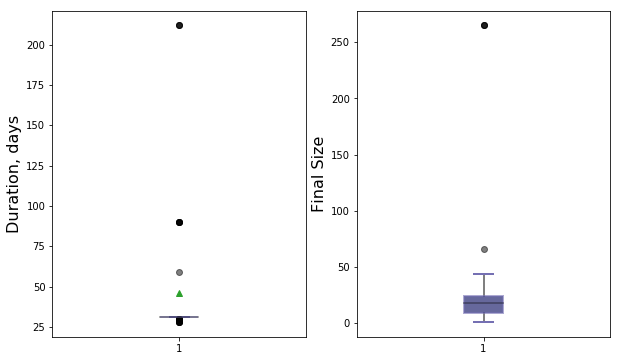

In [21]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(121)
bp = ax.boxplot(Data['Duration'].values, patch_artist=True, showmeans = True)
## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = 'teal' , alpha = 0.6)

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='grey', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='black', alpha = 0.3, linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='yellow', alpha=0.5)

plt.ylabel('Duration, days', fontsize =16)
# plt.ylim([0,40])
ax = fig.add_subplot(122)
bp = ax.boxplot(Data['Total Cases'].values, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#00035b' , alpha = 0.6)

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='grey', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='black', alpha = 0.3, linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='yellow', alpha=0.5)

plt.ylabel('Final Size', fontsize = 16)

Text(0,0.5,'Duration')

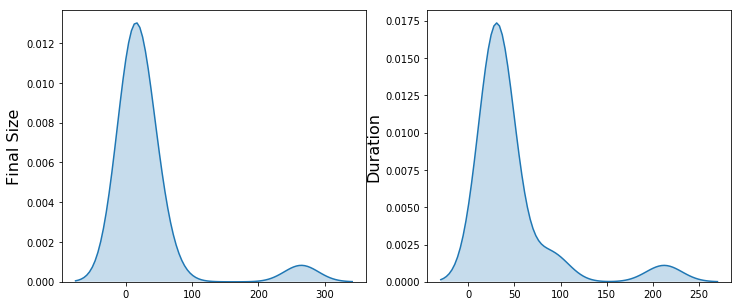

In [19]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
sns.kdeplot(Data['Total Cases'].values, shade = True)
plt.ylabel('Final Size', fontsize = 16)
plt.subplot(1,2,2)
sns.kdeplot(Data['Duration'].values, shade = True)
plt.ylabel('Duration', fontsize =16)

# Maps

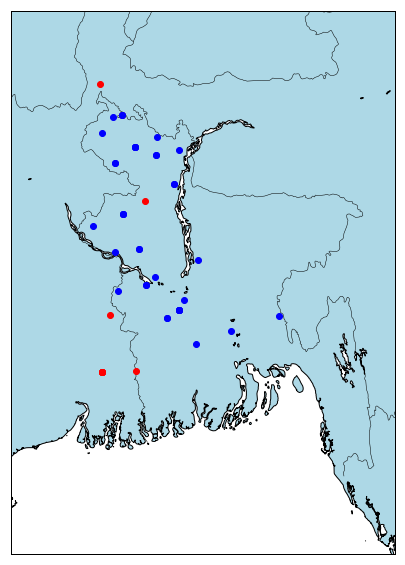

In [10]:
plt.figure(figsize = (10,10))
my_map = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.05,
    llcrnrlon=87, llcrnrlat=20.0,
    urcrnrlon=93, urcrnrlat=27.75)
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color = 'lightblue')
my_map.drawmapboundary()
 
# lons = [-135.3318, -134.8331, -134.6572]
# lats = [57.0799, 57.0894, 56.2399]
# xcoord[Case[2]], ycoord[Case[2]]
x_i,y_i = my_map(lons_india, lats_india)
my_map.plot(x_i, y_i, 'o', color = 'red', markersize=6)

# my_map.plot(my_map(xcoord[Case[25]], ycoord[Case[25]])[0],my_map(xcoord[Case[25]], ycoord[Case[25]])[1] , 'bo', markersize=6, color = 'red')
x_b,y_b = my_map(lons_ban, lats_ban)
my_map.plot(x_b, y_b, 'bo', markersize=6)
 
plt.show()

## Raster files

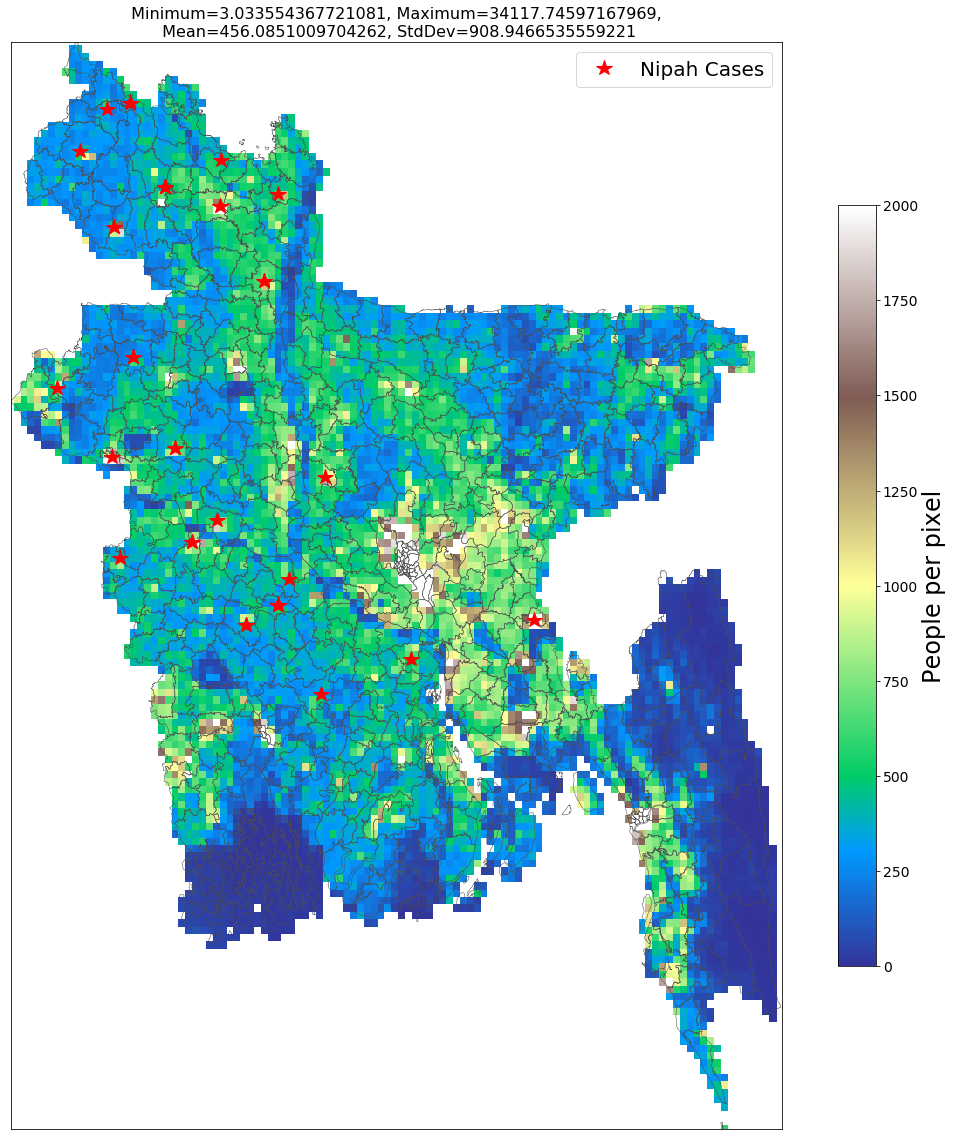

In [20]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
# pathToRaster =r'../Downloads/BGD_ppp_2010_adj_v2/BGD_ppp_2010_adj_v2.tif'
# pathToRaster =r'../Downloads/BGD_ppp_2010_adj_v2/BGD_ppp_UTM44.bil'
#change r5 to change resolution
pathToRaster =r'../Downloads/BGD_ppp_2010_adj_v2/output_r5_ac.tif'
scale = 50 #scale of resolution to 100m
gdata = gdal.Open(pathToRaster)


geo = gdata.GetGeoTransform()
data = gdata.GetRasterBand(1).ReadAsArray()
xres = geo[1]
yres = geo[5]


m =Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.05,
    llcrnrlon=88.0082, llcrnrlat=20.5945716,
    urcrnrlon=92.6882407, urcrnrlat=26.6345716)

m.readshapefile(r'../Downloads/bgd_border/bgd_admbnda_adm3_bbs_20180410','boundaries',drawbounds=True, color='0.3')

xmin = geo[0] + xres * 0.5
xmax = geo[0] + (xres * gdata.RasterXSize) - xres * 0.5
ymin = geo[3] + (yres * gdata.RasterYSize) + yres * 0.5
ymax = geo[3] - yres * 0.5

x,y = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
x,y = m(x,y)

cmap = plt.cm.terrain

cmap.set_under ('1.0')
cmap.set_bad('0.8')

im = m.pcolormesh(x,y, (data.T)*scale, cmap=cmap, vmin = 0, vmax = 2000)

cb = plt.colorbar( orientation='vertical', fraction=0.10, shrink=0.7)
cb.ax.tick_params(labelsize=14)
cb.set_label(r"People per pixel", size=24)

band = gdata.GetRasterBand(1)
stats = band.ComputeStatistics(0)
stats=[x*scale for x in stats]
plt.title(" Minimum={}, Maximum={}, \n Mean={}, StdDev={}".format( stats[0], stats[1], stats[2], stats[3] ), fontsize = 16)


x_b,y_b = m(lons_ban, lats_ban)
m.plot(x_b, y_b, marker = '*', markersize=16, color = 'red', linestyle ='', label ='Nipah Cases')


plt.legend(loc = 'upper right', fontsize = 20)
plt.show()

## Video

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)
my_map = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.05,
    llcrnrlon=87, llcrnrlat=20.0,
    urcrnrlon=93, urcrnrlat=27.75)
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color = 'lightblue')
my_map.drawmapboundary()

line1, = my_map.plot([], [], 'bo', markersize=6, color = 'red')

time_text = ax.text(0.05, 1.05, '', transform=ax.transAxes, color = 'k', fontsize = 30)


# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])

    time_text.set_text('')
    return line1, 

def animate(i):
    line1.set_data(my_map(xcoord[Case[i]], ycoord[Case[i]])[0],my_map(xcoord[Case[i]], ycoord[Case[i]])[1])
    time_text.set_text('Year {}, Month {}'.format(1999+int(i/12), (i % 12)+1))

    return line1, time_text

# call the animator, frames*(1/fps) is the speed of the animation.
# set number of frames to the length of your list of dataframes
anim = animation.FuncAnimation(fig, animate, frames=len(Case), init_func=init, interval=20, blit=True)

plt.xticks([])
plt.yticks([])

anim.save('Case.mp4', fps=8)

In [22]:
Data.to_csv('cases_durations.csv', sep=',')
